In [1]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
%matplotlib inline
from helpers import *
from datetime import datetime
from scipy.sparse import dia_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import bicgstab
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import lsqr
%load_ext autotime

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

with open("hyperParams.json") as f:
    instanceParams = json.load(f)

baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate

photoAlpha = instanceParams["photoParams"]["robustness"]
photoBeta = instanceParams["photoParams"]["scale"]
wei = instanceParams["smoothParams"]["weight"]

time: 7.79 ms


In [4]:
flow = np.zeros((480, 854, 2))
gt = mpimg.imread('../example_data/data/DAVIS/Annotations/480p/train/00023.png')
#gt = np.zeros((480, 854))

time: 6.59 ms


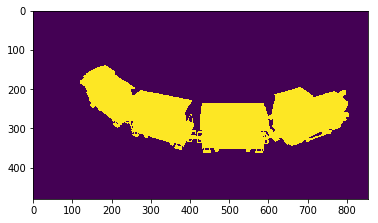

time: 195 ms


In [5]:
plt.imshow(gt)

In [6]:
flow = np.expand_dims(flow, 0)
gt = np.expand_dims(np.expand_dims(gt, 0), -1)

flow = tf.cast(flow, tf.float32)
gt = tf.cast(gt, tf.float32)
flow = tf.Variable(flow)

time: 49.4 ms


In [7]:
img0 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/train/00023.jpg"), channels=3, dtype=tf.uint8)
img1 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/train/00024.jpg"), channels=3, dtype=tf.uint8)

rgb0 = tf.cast(img0, tf.float32) - [[[[0,0,0]]]]
rgb1 = tf.cast(img1, tf.float32) - [[[[0,0,0]]]]

time: 9.73 ms


In [8]:
def mse_loss(f1, f2):
    return tf.reduce_sum(tf.square(f1 - f2), axis=-1, keep_dims=True)

time: 1.59 ms


In [9]:
kernel = tf.transpose(tf.constant([[[[0,-1,0],
                                     [0,1,0],
                                     [0,0,0]]],
                                   [[[0,0,0],
                                     [0,1,-1],
                                     [0,0,0]]],
                                   [[[0,0,0],
                                     [0,1,0],
                                     [0,-1,0]]],
                                   [[[0,0,0],
                                     [-1,1,0],
                                     [0,0,0]]]],
                                  dtype=tf.float32),perm=[3,2,1,0])

time: 10.1 ms


In [10]:
w = 1
GT_MASKS = []
for i in range(w):
    GT_MASKS.append(1 - tf.square(tf.nn.atrous_conv2d(gt, kernel, rate=i+1, padding='SAME')))

time: 10.2 ms


In [11]:
normalizer = tf.zeros((1, 480, 854, 2))

multiplier_masks = []
for i in range(w):
    multiplier_masks.append([])

for i in range(w):
    j = i + 1
    gt_mask = GT_MASKS[i]

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([gt_mask[:,:,j:854,0],
                           tf.zeros((1, 480, j), dtype=tf.float32)], axis=2), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([tf.zeros((1, j, 854), dtype=tf.float32),
                           gt_mask[:,0:(480-j),:,1]], axis=1), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([tf.zeros((1, 480, j), dtype=tf.float32),
                           gt_mask[:,:,0:(854-j),2]], axis=2), axis=-1), (1, 1, 1, 2)))

    multiplier_masks[i].append(
        tf.tile(
            tf.expand_dims(
                tf.concat([gt_mask[:,j:480,:,3],
                           tf.zeros((1, j, 854), dtype=tf.float32)], axis=1), axis=-1), (1, 1, 1, 2)))

    normalizer += multiplier_masks[i][0] + multiplier_masks[i][1] + multiplier_masks[i][2] + multiplier_masks[i][3]

# Remove 0's in normalizer
normalizer += 4 * w * tf.cast(tf.equal(normalizer, 0), dtype=tf.float32)
normalizer.shape

TensorShape([Dimension(1), Dimension(480), Dimension(854), Dimension(2)])

time: 73.9 ms


In [12]:
m0 = multiplier_masks[0][0].eval(session=tf.Session())[0,:,:,0]
m1 = multiplier_masks[0][1].eval(session=tf.Session())[0,:,:,0]
m2 = multiplier_masks[0][2].eval(session=tf.Session())[0,:,:,0]
m3 = multiplier_masks[0][3].eval(session=tf.Session())[0,:,:,0]

m4 = normalizer.eval(session=tf.Session())[0,:,:,0]

time: 1.4 s


In [22]:
H, W = 480, 854
gamma = 8.0
nelem = H * W
data0 = np.array([
    np.concatenate((np.array([0]), -m0.ravel()))[:nelem],
    np.concatenate((-m1.ravel()[W:], np.repeat(0, W)))[:nelem],
    np.concatenate((-m2.ravel()[1:], np.array([0])))[:nelem],
    np.concatenate((np.repeat(0, W), -m3.ravel()))[:nelem]
])
offset0 = [1, -W, -1, W]

A0 = dia_matrix((data0, offset0), shape=(nelem, nelem))

A = A0 + dia_matrix(((gamma + m4).ravel(), 0), shape=(nelem, nelem))

time: 117 ms


In [23]:
def ls_solve(flow):
    H, W = 480, 854
    nelem = H * W
    shp = (nelem, nelem)

    u = bicgstab(A, (flow[0,:,:,0] * gamma).ravel())[0].reshape((H, W))
    v = bicgstab(A, (flow[0,:,:,1] * gamma).ravel())[0].reshape((H, W))

    return np.expand_dims(np.dstack([u, v]), 0).astype(np.float32)

time: 5.03 ms


In [24]:
gammaTensor = tf.placeholder(tf.float32,shape=[])
golTensor = tf.placeholder(tf.float32,shape=[])

def adm_loss_fn(flow, gol, gamma):
    pLoss = photoLoss(flow, rgb0, rgb1, photoAlpha, photoBeta)
    actual_smooth_loss = asymmetricSmoothLoss(flow, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
    actual_smooth_loss = tf.stop_gradient(actual_smooth_loss)
    flow_copy = flow * 1.0
    flow_copy = tf.stop_gradient(flow_copy)
    fhat = tf.py_func(ls_solve, [flow_copy], tf.float32)
    sLoss = asymmetricSmoothLoss(fhat, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
    mLoss = mse_loss(flow, fhat)

    return pLoss, sLoss, gamma * mLoss, actual_smooth_loss, fhat

time: 10.1 ms


In [25]:
photo_loss, smooth_loss, eucl_loss, as_loss, fhat = adm_loss_fn(flow, golTensor, gammaTensor)
adm_loss = photo_loss + smooth_loss + eucl_loss

time: 121 ms


In [26]:
sGrad = tf.gradients(smooth_loss, fhat)
pGrad = tf.gradients(photo_loss, flow)
mGrad = tf.gradients(eucl_loss, flow)
tGrad = tf.gradients(adm_loss, flow)

time: 671 ms


In [27]:
solver, solver_op, learningRateTensor = attachSolver(adm_loss)

time: 347 ms


In [28]:
itr = 500
ada_gol = np.linspace(10, 20, itr + 1)

time: 1.68 ms


In [29]:
init = tf.global_variables_initializer()
mLosses, sLosses, pLosses, asLosses = [], [], [], []
tGrads, sGrads, pGrads, mGrads = [], [], [], []
flows, flow_props = [], []

print_freq = 10
with tf.Session() as sess:
    sess.run(init)
    gol = 8.0
    for i in range(1, itr + 2):
        feed_dict = {
            learningRateTensor: 1.0,
            gammaTensor: gol * 10000,
            golTensor: gol
        }
        _, s, p, m, f, fp, asl = sess.run([solver_op,
                                      smooth_loss,
                                      photo_loss,
                                      eucl_loss,
                                      flow,
                                      fhat,
                                      as_loss], feed_dict = feed_dict)

        if i % print_freq == 1:
            print(i)
            flows.append(deepcopy(f[0]))
            flow_props.append(deepcopy(fp[0]))
            sLosses.append(np.mean(s))
            asLosses.append(np.mean(asl))
            pLosses.append(np.mean(p))
            mLosses.append(np.mean(m))
            print "Photo loss: %f" % float(pLosses[-1])
            print "Smooth loss after LS: %f" % sLosses[-1]
            print "Smooth loss from \"network\": %f" % np.mean(asl)

1
Photo loss: 2895.463867
Smooth loss after LS: 0.000004
Smooth loss from "network": 0.000004
11
Photo loss: 1360.284180
Smooth loss after LS: 0.662244
Smooth loss from "network": 1.484598
21
Photo loss: 1320.720703
Smooth loss after LS: 0.151698
Smooth loss from "network": 0.313795
31
Photo loss: 1143.760498
Smooth loss after LS: 0.056074
Smooth loss from "network": 0.094296
41
Photo loss: 989.235535
Smooth loss after LS: 0.042702
Smooth loss from "network": 0.069215
51
Photo loss: 861.205627
Smooth loss after LS: 0.031333
Smooth loss from "network": 0.045964
61
Photo loss: 754.354675
Smooth loss after LS: 0.025087
Smooth loss from "network": 0.033632
71
Photo loss: 661.310608
Smooth loss after LS: 0.021678
Smooth loss from "network": 0.027621
81
Photo loss: 580.661438
Smooth loss after LS: 0.019572
Smooth loss from "network": 0.024302
91
Photo loss: 515.320190
Smooth loss after LS: 0.018083
Smooth loss from "network": 0.022160
101
Photo loss: 462.210815
Smooth loss after LS: 0.016865

In [30]:
mLosses = np.array(mLosses)
sLosses = np.array(sLosses)
pLosses = np.array(pLosses)
asLosses = np.array(asLosses)
tLosses = pLosses + mLosses

time: 2.6 ms


max flow: 8.7021
flow range:
u = -4.448 .. 8.423
v = -6.787 .. 4.242


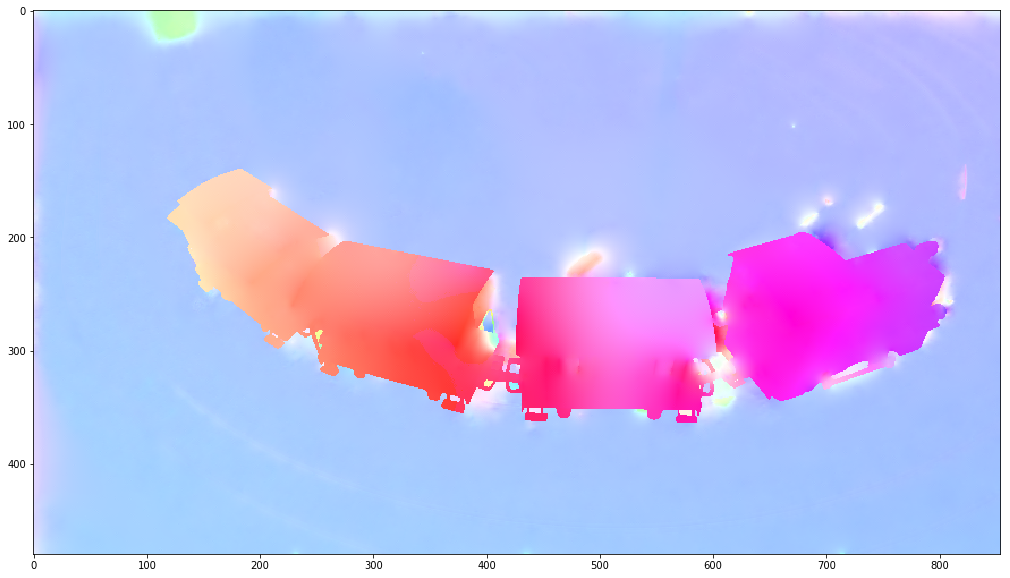

time: 675 ms


In [31]:
plt.figure(figsize=(20, 10))
plt.imshow(flow_to_image(flows[-1]))